In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('prosperLoanData.csv')

## Data Preparation

In [3]:
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [4]:
df.shape

(113937, 81)

## ACCESS 

As the volume of the dataset is big, assessment and cleaning process will be iterative throughout the process.

In [5]:
# Run the code below to see all rows and columns, not collapsed
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# High-level assessment of the datadset
print(df.shape),
print(df.info())

(113937, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  

In [6]:
# Check for any duplicate 
df.duplicated().sum()

0

It seems like there is no duplicate on the surface level. However, let's check if there is hidden duplicates by checking **duplicated() by listingkey() column**.

In [7]:
# Check for duplicates by 'listingkey' 

df[df['ListingKey'].duplicated()].shape[0]

871

In [8]:
# Evaluate the first three duplicates and see whether we could leave or delete them
df.query("ListingKey == '0F043596202561788EA13D5' or ListingKey == '0A0635972629771021E38F3' or ListingKey =='2D2635984503681189056B4'")

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
8,0F043596202561788EA13D5,1023355,2013-12-02 10:43:39.117000000,NaN,36,Current,NaN,0.07620,0.0629,0.0529,0.05221,0.0099,0.04231,7.0,AA,9.0,7,IL,Food Service,Employed,269.0,True,False,NaN,2013-12-02 10:43:39,820.0,839.0,1993-04-01 00:00:00,17.0,16.0,32.0,12,219.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,9906.0,0.11,77696.0,29.0,1.00,1.0,0.25,"$25,000-49,999",True,3333.333333,02163700809231365A56A1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,3,121268,10000,2013-12-12 00:00:00,Q4 2013,49A53699682291323D04D66,305.54,611.08,505.58,105.5,-16.77,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
9,0F043596202561788EA13D5,1023355,2013-12-02 10:43:39.117000000,NaN,36,Current,NaN,0.07620,0.0629,0.0529,0.05221,0.0099,0.04231,7.0,AA,11.0,7,IL,Food Service,Employed,269.0,True,False,NaN,2013-12-02 10:43:39,820.0,839.0,1993-04-01 00:00:00,17.0,16.0,32.0,12,219.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,9906.0,0.11,77696.0,29.0,1.00,1.0,0.25,"$25,000-49,999",True,3333.333333,02163700809231365A56A1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,3,121268,10000,2013-12-12 00:00:00,Q4 2013,49A53699682291323D04D66,305.54,611.08,505.58,105.5,-16.77,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
998,0A0635972629771021E38F3,1055932,2013-12-18 14:25:17.053000000,NaN,60,Current,NaN,0.17710,0.1535,0.1435,0.13507,0.0599,0.07517,5.0,B,6.0,1,MD,Other,Employed,100.0,True,False,NaN,2014-02-08 11:39:13,760.0,779.0,1994-11-01 00:00:00,16.0,16.0,34.0,15,623.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,8028.0,0.27,14190.0,32.0,0.96,1.0,0.35,"$25,000-49,999",True,3750.000000,CB643706582969191E8C26B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1,132043,10000,2014-02-12 00:00:00,Q1 2014,98A937006186534818378B9,239.74,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
999,0A0635972629771021E38F3,1055932,2013-12-18 14:25:17.053000000,NaN,60,Current,NaN,0.17710,0.1535,0.1435,0.13507,0.0599,0.07517,5.0,B,7.0,1,MD,Other,Employed,100.0,True,False,NaN,2014-02-08 11:39:13,760.0,779.0,1994-11-01 00:00:00,16.0,16.0,34.0,15,623.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,8028.0,0.27,14190.0,32.0,0.96,1.0,0.35,"$25,000-49,999",True,3750.000000,CB643706582969191E8C26B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1,132043,10000,2014-02-12 00:00:00,Q1 2014,98A937006186534818378B9,239.74,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
1554,2D2635984503681189056B4,1097584,2014-01-11 07:50:08.037000000,NaN,60,Current,NaN,0.14528,0.1224,0.1124,0.10731,0.0424,0.06491,5.0,B,9.0,1,NJ,Police Officer/Correction Officer,Employed,107.0,

If you look at duplicated entries by ListingKey, we can see each duplicates are talking about same loans. For example, if you look at the loan (listingkey: 0F043596202561788EA13D5), its creation-date is same with all the other variables same. The only difference is the prosper-score. We can assume these two rows are talking about the same loan case but with wrong prosper-score entry. If is safe to delete all these duplicated rows as we cannot assume borrowers' loan variables, arbitrarily. This will be dealt in the cleaning section.

## Data Cleaning

This section will clean the dataset for its tidiness and quality.

Quality

* Duplicated entries
* Nan entries
* Cancelled loan status which is not created loan in the first place
* Disconnected credit information: creditgrade(pre-2009) prosperrating(post-2009)
* Wrong datatypes
* Object columns to ordered-categorical column
*'listingcategory (numeric)' to string categorical data
* Too complicated/long column names
* Tidiness

* Too many information in one observational unit

In [9]:
# Before any cleaning, make a copy of the original dataset
df = df.copy()

**Convert Column Names**
**Drop duplicated columns**

In [10]:
# Standardise column capitalisation to .lower()
df.columns = df.columns.str.lower()

# Drop duplicates by listingkey
df.drop_duplicates(subset = 'listingkey', inplace = True)

# Confirm. You should get False
df.listingkey.duplicated().any()

False

**Select only columns of interest**

In [11]:
# Create a new dataframe only with columns of interest
cols = ['listingcreationdate', 'creditgrade', 'term', 'loanstatus', 'borrowerapr', 'borrowerrate', 
        'prosperrating (alpha)', 'listingcategory (numeric)', 'employmentstatus', 'debttoincomeratio', 'incomerange',
        'loanoriginalamount']
df = df.loc[:, cols]

# Confirm
df.head(1)

,listingcreationdate,creditgrade,term,loanstatus,borrowerapr,borrowerrate,prosperrating (alpha),listingcategory (numeric),employmentstatus,debttoincomeratio,incomerange,loanoriginalamount
0,2007-08-26 19:09:29.263000000,C,36,Completed,0.16516,0.158,NaN,0,Self-employed,0.17,"$25,000-49,999",9425


**Simplify Column Names**

In [12]:
# Rename columns for simplicity 
df.rename(columns = {'listingcreationdate': 'listingdate',
                    'prosperrating (alpha)': 'prosperrating_a', 
                    'loanoriginalamount': 'original_amount',
                    'employmentstatus': 'employment',
                    'debttoincomeratio': 'debttoincome',
                    'listingcategory (numeric)': 'listing_cat'
                    }, inplace = True)

**Combine pre-2009 and post-2009 prosper rating**

**Create a numeric rating column for both pre- and post-2009 prosper rating**

In [13]:
# Join pre-2009 creditgrade data and post-2009 prosperrating_a data by using numpy.where()
# If creditgrade column is not null, extract that info. If not, use the prosperrating_a data.
df['prosperrating_a'] = np.where(df['creditgrade'].notnull(), df['creditgrade'], df['prosperrating_a'])

# Replace prosperrating null values to 'NC'
mapping = {np.NaN: "NC", 
          np.nan: "NC"}
df.prosperrating_a = df['prosperrating_a'].replace(mapping)

# Now drop creditgrade column
df.drop(columns = 'creditgrade', inplace = True)

# Confirm
print(df.prosperrating_a.unique())

['C' 'A' 'HR' 'D' 'B' 'E' 'AA' 'NC']


In [14]:
# Create propserrating_numeric column by converting alpha system values
mapping = {'NC': 0, 'HR': 1, 
           'E': 2,'D': 3, 
           'C': 4, 'B': 5, 
           'A': 6, 'AA': 7}

df['prosperrating_n'] = df['prosperrating_a'].replace(mapping)

# Confirm
df.prosperrating_n.value_counts()

4    23745
5    19757
3    19323
6    17705
2    13005
1    10425
7     8834
0      272
Name: prosperrating_n, dtype: int64

**Clean Null Values**

**Drop 'Cancelled' loans**

In [15]:
# Check how many null values are there by columns
df.isnull().sum()

listingdate           0
term                  0
loanstatus            0
borrowerapr          25
borrowerrate          0
prosperrating_a       0
listing_cat           0
employment         2255
debttoincome       8472
incomerange           0
original_amount       0
prosperrating_n       0
dtype: int64

In [16]:
# Employment: Replace missing employment values with 'Not available'
df['employment'] = df['employment'].fillna('Not available')

# Confirm
df.isnull().sum()

listingdate           0
term                  0
loanstatus            0
borrowerapr          25
borrowerrate          0
prosperrating_a       0
listing_cat           0
employment            0
debttoincome       8472
incomerange           0
original_amount       0
prosperrating_n       0
dtype: int64

In [17]:
# borrowerAPR and debt-to-income: fill nulls with mean value
df.borrowerapr = df['borrowerapr'].fillna(df['borrowerapr'].mean())
df.debttoincome = df['debttoincome'].fillna(df['debttoincome'].mean())

df.isnull().sum()

listingdate        0
term               0
loanstatus         0
borrowerapr        0
borrowerrate       0
prosperrating_a    0
listing_cat        0
employment         0
debttoincome       0
incomerange        0
original_amount    0
prosperrating_n    0
dtype: int64

In [18]:
# Drop cancelled loans which is loans that are not created in the first place
df = df[df['loanstatus'] != 'Cancelled']

# Confirm. You should get zero.
df.query("loanstatus == 'Cancelled'").shape[0]

0

**Convert datatypes**

In [19]:
df['listingdate'] = pd.to_datetime(df['listingdate'])

# Code below causes an error. NA's cannot be stored in integer arrays. Either fill them with some value or drop.
# OR use Int64 to override
# df['prosperrating_n'] = df['prosperrating_n'].astype('int64')

In [20]:
print(df.loanstatus.value_counts())
print(df.employment.value_counts())

Current                   55730
Completed                 38061
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        800
Past Due (31-60 days)       361
Past Due (61-90 days)       311
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      203
Past Due (>120 days)         16
Name: loanstatus, dtype: int64
Employed         66598
Full-time        26353
Not available     7598
Self-employed     6052
Other             3742
Part-time         1088
Not employed       835
Retired            795
Name: employment, dtype: int64


**Replace values to remove unnecessary noise in the data**

In [21]:
# For visualisation purpose, aggregate the loan status values into simpler categorical level.
# There are too many categorical levels which will make unnecessary noise in the visualisation.
mapping = {'Past Due (1-15 days)': 'Past Due',
             'Past Due (16-30 days)': 'Past Due', 
              'Past Due (31-60 days)': 'Past Due', 
              'Past Due (61-90 days)': 'Past Due', 
              'Past Due (91-120 days)': 'Past Due', 
              'Past Due (>120 days)': 'Past Due',
             'FinalPaymentInProgress': 'Completed'}
df['loanstatus'] = df['loanstatus'].replace(mapping)

df['incomerange'] = df['incomerange'].replace("$0", "Not employed")
df['employment'] = df['employment'].replace('Retired', 'Not employed')

# Confirm
print(df.loanstatus.value_counts())
print(df.incomerange.value_counts())
print(df.employment.value_counts())

Current       55730
Completed     38264
Chargedoff    11992
Defaulted      5018
Past Due       2057
Name: loanstatus, dtype: int64
$25,000-49,999    31939
$50,000-74,999    30749
$100,000+         17188
$75,000-99,999    16780
Not displayed      7737
$1-24,999          7241
Not employed       1427
Name: incomerange, dtype: int64
Employed         66598
Full-time        26353
Not available     7598
Self-employed     6052
Other             3742
Not employed      1630
Part-time         1088
Name: employment, dtype: int64


**Convert datatype to ordered-categorical dtype**

In [22]:
# Convert to ordered-categorical columns
ordinal_var_dict = {'loanstatus': ['Completed', 'Current', 'Past Due', 'Chargedoff', 'Defaulted'],
                    'employment': ['Not employed', 'Not available', 'Other','Part-time', 'Self-employed', 'Full-time', 'Employed'],
                    'incomerange': ['Not displayed', 'Not employed', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+'],
                    'prosperrating_a': ['NC', 'HR', 'E', 'D', 'C', 'B', 'A', 'AA']}
    
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

# Confirm
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113061 entries, 0 to 113936
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   listingdate      113061 non-null  datetime64[ns]
 1   term             113061 non-null  int64         
 2   loanstatus       113061 non-null  category      
 3   borrowerapr      113061 non-null  float64       
 4   borrowerrate     113061 non-null  float64       
 5   prosperrating_a  113061 non-null  category      
 6   listing_cat      113061 non-null  int64         
 7   employment       113061 non-null  category      
 8   debttoincome     113061 non-null  float64       
 9   incomerange      113061 non-null  category      
 10  original_amount  113061 non-null  int64         
 11  prosperrating_n  113061 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(3), int64(4)
memory usage: 8.2 MB
None


**Convert numeric variable to nominal**

In [23]:
mapping = {0: 'Not available', 1: 'Debt consolidation', 2: 'Home improvement', 3: 'Business', 4: 'Personal loan', 
           5: 'Student use', 6: 'Auto', 7: 'Other', 8: 'Baby and adoption', 9: 'Boat', 10: 'Cosmetic procedure',
           11: 'Engagement ring', 12: 'Green laons', 13: 'Household expenses', 14: 'Large purchases', 15: 'Medical or dental', 
           16: 'Motorcycle', 17: 'RV', 18: 'Taxes', 19: 'Vacation', 20: 'Wedding loans'}

df['listing_cat'].replace(mapping, inplace = True)

# Confirm
df['listing_cat'].unique()

array(['Not available', 'Home improvement', 'Motorcycle',
       'Debt consolidation', 'Other', 'Household expenses', 'Auto',
       'Medical or dental', 'Wedding loans', 'Vacation', 'Business',
       'Taxes', 'Baby and adoption', 'Personal loan', 'Engagement ring',
       'Large purchases', 'Student use', 'Boat', 'RV',
       'Cosmetic procedure', 'Green laons'], dtype=object)

In [24]:
# Reset index and drop the original index 
df = df.reset_index(drop = True)

**Structure of dataset**

After initial cleaning process, the dataset contains 113,937 rows and 22 columns. Data types of columns include datetime, numerical, and non-numeric variables (e.g. categorical, nominal, ordinal). The categorical variables below, in specific, are ordered with the following levels:

* prosperrating_a: NC - HR - E - D - C - B - A - AA
* prosperrating_n: 0(N/A) - 1(HR) - 2(E) - 3(D) - 4(C) - 5(B) - 6(A) - 7(AA)
* loanstatus: Completed - Current - Past Due - Chargedoff - Completed

**Other features:**

* listingdate: the date the listing was created
* term: the length of the loan (in months)
* borrowerAPR: the borrower's annual percentage rate for the loan
* prosperrating_a: the prosper rating assigned
* listing_cat: the category of the listing that the borrower selected when posting their listing

**What features in the dataset do you think will help support your investigation into your feature(s) of interest?**

* The main focus of this project is exploring how the features play out in predicting loan status with visualisations. Visualisations include univariate, bivariate and multivariate plots. The main focus is to evaluate the predicting power of debt-to-income ratio, original amount, income range, prosper-rating.



## EDA: Exploratory Data Analysis

**1. Univariate Analysis**

* This section will focus on understanding the data deeper by looking at each feature's distribution, frequencies, ....

In [25]:
# Set the color theme for later use
basic = sns.color_palette()[0]
plt.style.use("dark_background")

**Loans Per Year**

In [26]:
# Creat a column for listing year
df['year'] = df['listingdate'].dt.year 

# Creat a temporary dataframe for listing year and count
year_df = df.groupby("year").listingdate.count().reset_index()
year_df

,year,listingdate
0,2005,23
1,2006,6209
2,2007,11557
3,2008,11262
4,2009,2206
5,2010,5530
6,2011,11442
7,2012,19556
8,2013,34791
9,2014,10485


In [27]:
df.groupby("year")['listingdate'].max()

year
2005   2005-12-29 19:53:41.000
2006   2006-12-31 22:19:25.897
2007   2007-12-31 23:58:02.303
2008   2008-10-16 20:58:14.297
2009   2009-12-31 20:38:37.423
2010   2010-12-31 16:11:23.507
2011   2011-12-31 21:38:03.490
2012   2012-12-31 23:23:52.907
2013   2013-12-31 22:28:19.927
2014   2014-03-10 12:20:53.760
Name: listingdate, dtype: datetime64[ns]

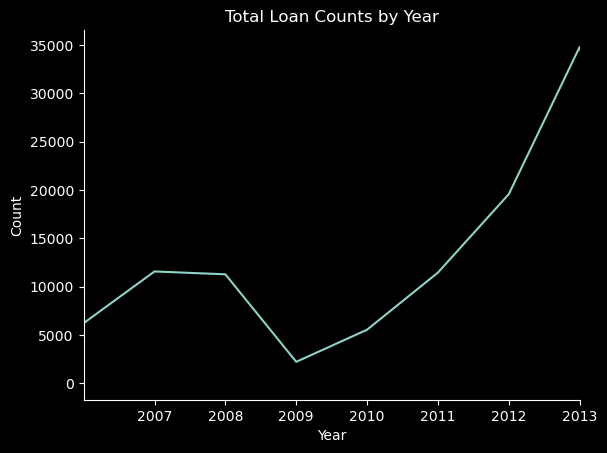

In [28]:
sns.lineplot(data = year_df, x = 'year', y = 'listingdate')
plt.title("Total Loan Counts by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xlim((2006, 2013))
plt.xticks([2007, 2008, 2009, 2010, 2011, 2012, 2013], [2007, 2008, 2009, 2010, 2011, 2012, 2013])

sns.despine()
plt.show();

The graph of listed loan counts shows wide fluctuations during the given period. The year 2009 had the lowest number of loans made. Then the loan counts gradually rise to peak in 2013 with almost 35,000 loans made. We excluded the year 2014 as the data was gathered only until March 2014 whilst other years have all year round data approx. from January to December.

**Prosper Rating**

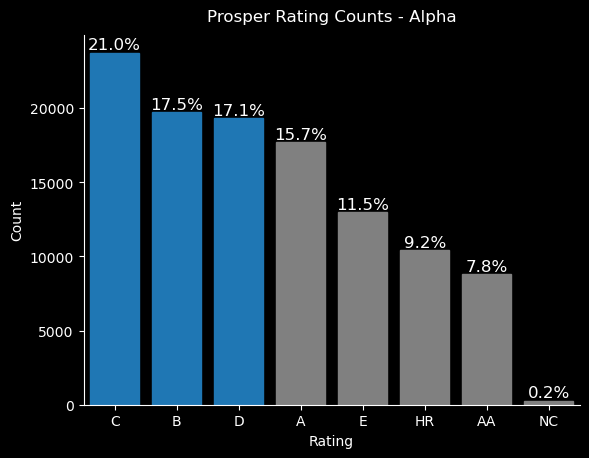

In [29]:
# Plot for 'prosperrating_a'
order = df.prosperrating_a.value_counts().index
ax = sns.countplot(data = df, x = 'prosperrating_a', order = order)
ax.set_title('Prosper Rating Counts - Alpha', pad = 10)
ax.set_xlabel('Rating')
ax.set_ylabel('Count')

# Add annotation
for p in ax.patches:
    total = len(df.prosperrating_a)
    percentage = "{:.1f}%".format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize = 12, ha = 'center', va = 'bottom')
    sns.despine()
    
# Highlight top 3 bars 
for bar in ax.patches: 
    if bar.get_height() > 18000:
        bar.set_color(basic)
    else:
        bar.set_color('grey')

plt.show();

One can see that 'C' is the most frequent rating prosper rating system, recording 21%. This is followed by 'B'(17.5%), 'C'(17.1%) and 'A'(15.7%). This means about 55.6% of the borrowers are in C, B or D grade in our dataset. This is not surprising as higher grade like AA or A requires borrowers to meet more stringent criterias.

**Loan Term**

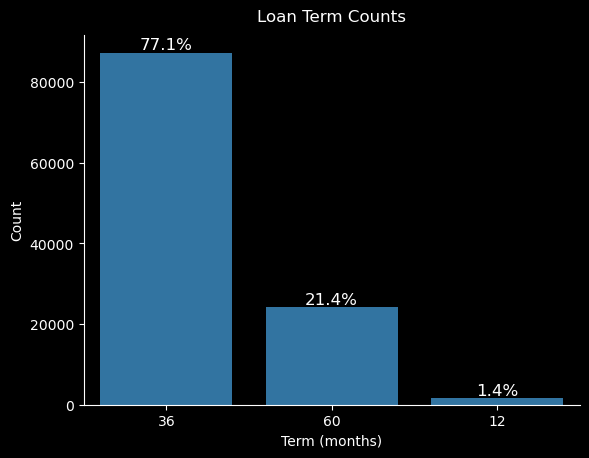

In [30]:
term_order = df.term.value_counts().index

ax = sns.countplot(data = df, x = 'term', color = basic, order = term_order)
ax.set_title("Loan Term Counts", pad = 10)
ax.set_xlabel('Term (months)')
ax.set_ylabel('Count')

for p in ax.patches:
    total = df.term.count()
    percentage = "{:.1f}%".format(100*p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), fontsize = 12, ha = 'center', va = 'bottom')
    sns.despine()

plt.show();

The distribution of loan term shows that the 36-month type represents roughly 77% of the dataset, making it the most popular one. This is followed by 60-month term (21.4%) and then 12-month (1.4%).

**Loan Status**

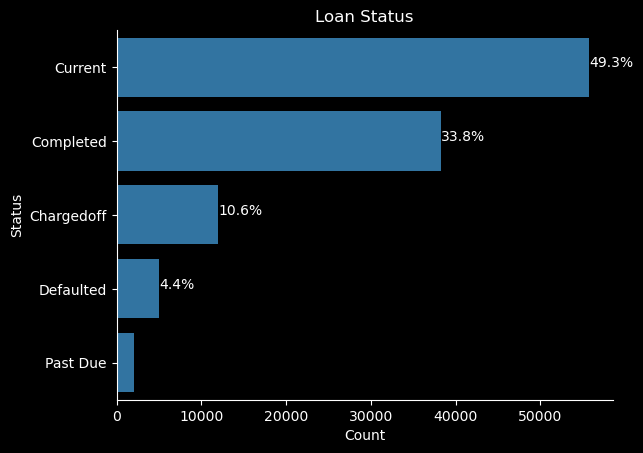

In [31]:
ax = sns.countplot(data = df, y = 'loanstatus', order = df.loanstatus.value_counts().index, 
                    color = basic)

# Annotate top 4 bars
a = 0
for p in ax.patches:
    if a < 4:
        total = len(df.loanstatus)
        percentage = "{:.1f}%".format(100 * p.get_width() / total)
        x = p.get_x() + p.get_width()
        y = (p.get_y() + p.get_height() / 2)
        ax.annotate(percentage, (x, y))
        a += 1
plt.title("Loan Status")
plt.ylabel('Status')
plt.xlabel('Count')

sns.despine()
plt.show();

The graph shows that 'current' status holds the majority of the loans in out dataset, occupying approximately 50%. This is followed by 'completed' status (33.8%), chargedoff (10.6%), and Defaulted (4.4%). There is a significant gap between these the top two status and the rest.

**BorrowerAPR & Borrower-Rate**

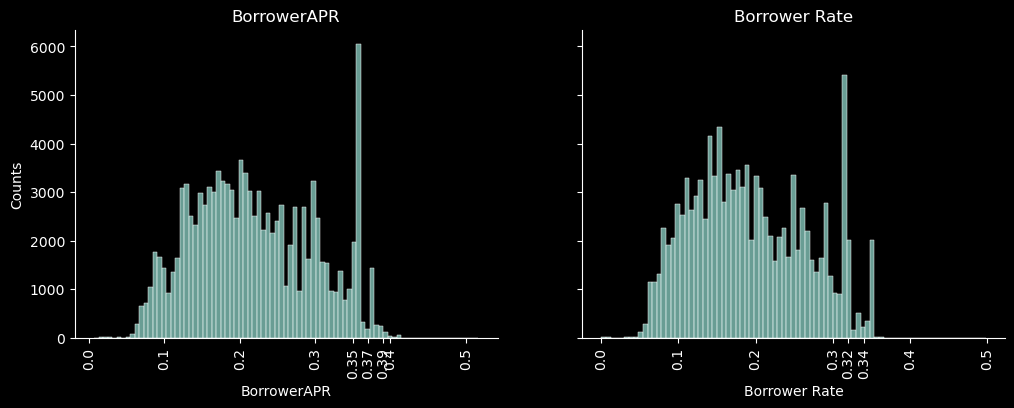

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [12, 4], sharey = True)

# BorrowerAPR
apr_bins = np.arange(df.borrowerapr.min(), df.borrowerapr.max() + 0.006, 0.006)
sns.histplot(data = df, x = 'borrowerapr', bins = apr_bins, ax = ax1)
# To see where exactly the peak is, set close xticks around the peak
apr_xticks = [0.0, 0.1, 0.2, 0.3, 0.35, 0.37, 0.39, 0.4, 0.5]
ax1.set_xticks(apr_xticks, apr_xticks, rotation = 90)
ax1.set_title('BorrowerAPR')
ax1.set_xlabel("BorrowerAPR")
ax1.set_ylabel('Counts')

# Borrower Rate
rate_bins = np.arange(df.borrowerrate.min(), df.borrowerrate.max() + 0.006, 0.006)
sns.histplot(data = df, x = 'borrowerrate', bins = rate_bins, ax = ax2)
rate_xticks = [0.0, 0.1, 0.2, 0.3, 0.32, 0.34, 0.4, 0.5]
ax2.set_xticks(rate_xticks, rate_xticks, rotation = 90)
ax2.set_title('Borrower Rate')
ax2.set_xlabel("Borrower Rate")

sns.despine()
plt.show();

The distribution of both borrowerAPR and borrowerRate is almost identical with a noticeable peak within the range of [0.32, 0.37). This demonstrates that 0.32 - 0.37 borrower APR/rate range is the most common in our dataset. High-correlation between these two features is expected of course as they are similar concept. They both are right-skewed.

**Listing Category**

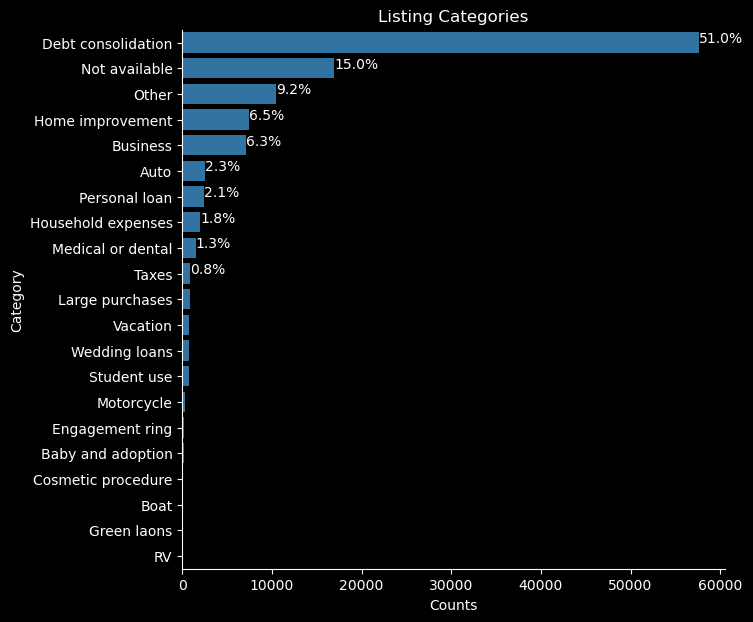

In [33]:
order = df.listing_cat.value_counts().index

plt.figure(figsize = (7, 7))
ax = sns.countplot(data = df, y = 'listing_cat', order = order, color = basic)
plt.title("Listing Categories")
plt.ylabel("Category")
plt.xlabel("Counts")

# Add annotation to top 10 bars only
a = 0
for p in ax.patches:
    if a < 10:
        total = len(df.listing_cat)
        percentage = "{:.1f}%".format(100*p.get_width() / total)
        x = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))
        a += 1

sns.despine()
plt.show();   

Out of listing categories, debt consolidation occupies about half of the whole counts, recording 51% percentage point. This is followed by home improvement (6.5%), except listing category 'not available' or not specified.

**Borrower Employment Status**

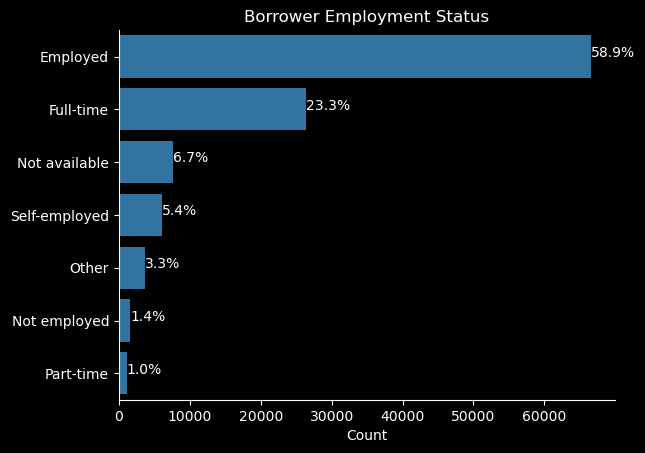

In [34]:
order = df.employment.value_counts().index

ax = sns.countplot(y = df['employment'], color = basic, order = order)

for p in ax.patches:
    total = len(df.employment)
    percentage = "{:.1f}%".format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))
    
plt.title("Borrower Employment Status")
plt.ylabel("")
plt.xlabel("Count")
sns.despine()
plt.show();

The chart indicates that 'employed' is the most common employment status of the borrowers (58.9%) and full-time being next (23.3%). This might be a spitting picture of the loan industry that employed candidate have easier access to loans, while part-time/not-employed candidates often get rejected.

**Income Range**

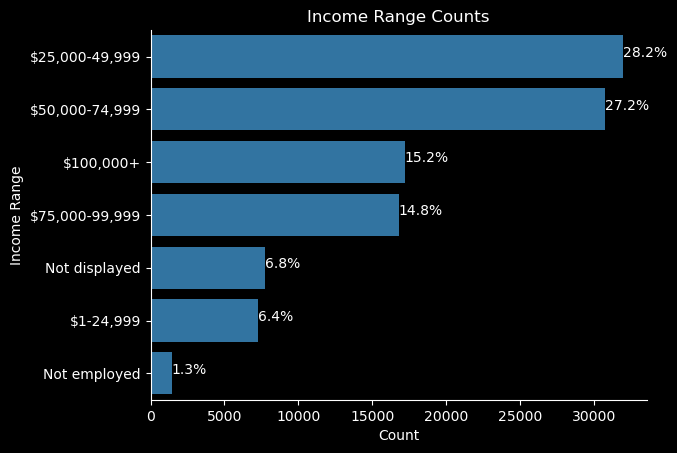

In [35]:
order = df.incomerange.value_counts().index 

ax = sns.countplot(y = df['incomerange'], color = basic, order = order)
sns.despine()
plt.title("Income Range Counts")
plt.xlabel("Count")
plt.ylabel("Income Range")

for p in ax.patches:
    total = len(df.incomerange)
    percentage = "{:.1f}%".format(p.get_width() / total * 100)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

plt.show();

The income range 25,000 - 49,999 and 50,000 - 74,999 is the most common with 28.2% and 27.2%, respectively. These two income levels take up more than 50% of our dataset. Then, borrowers with over 100k income occupies 15.2% which is almost on par with those of income level 75k-99k.

**Loan Original Amount**

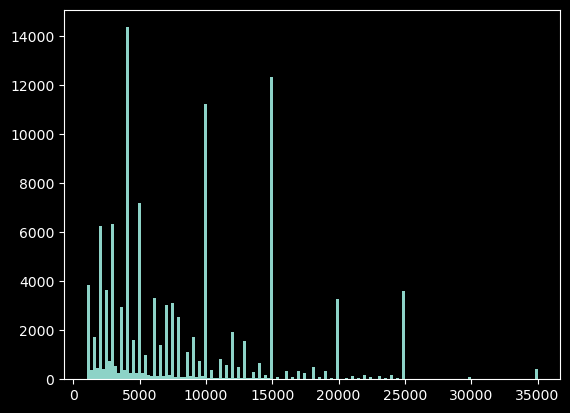

count    113061.000000
mean       8315.054838
std        6236.987928
min        1000.000000
25%        4000.000000
50%        6300.000000
75%       12000.000000
max       35000.000000
Name: original_amount, dtype: float64


In [36]:
plt.hist(df.original_amount, bins = 150)
plt.show();

print(df.original_amount.describe())

The original amount is right-skewed. Thus, logarithmic transformation is applied like below.

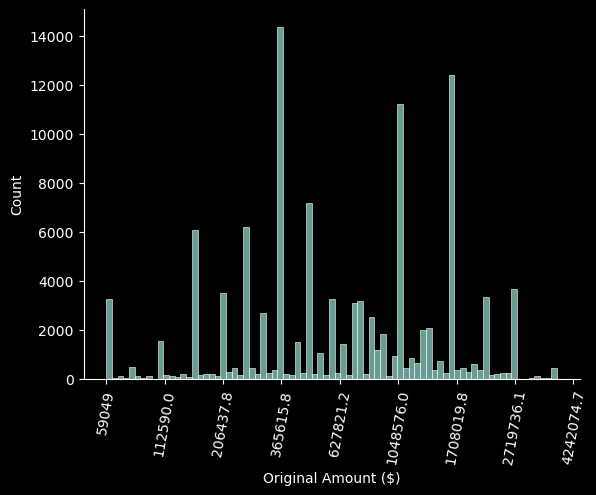

In [37]:
# Define a logarithmic transformation function
def log_trans(x, inverse = False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(x, 10)

sns.histplot(data = df, x = df['original_amount'].apply(log_trans))
or_ticks = [3, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6]
plt.xticks(or_ticks, [round(log_trans(v, inverse=True),1) for v in or_ticks],
            rotation = 80)

plt.xlabel("Original Amount ($)")
sns.despine()
plt.show();

Given the step spikes and step fall behind, it seems like there are industry standards in original loan amount, with 385615.8 being the most popular amount in our dataset. Next common loan amount is 1708019.8.

**Debt-to-income Ratio**

count    113061.000000
mean          0.276037
std           0.532599
min           0.000000
25%           0.150000
50%           0.230000
75%           0.310000
max          10.010000
Name: debttoincome, dtype: float64


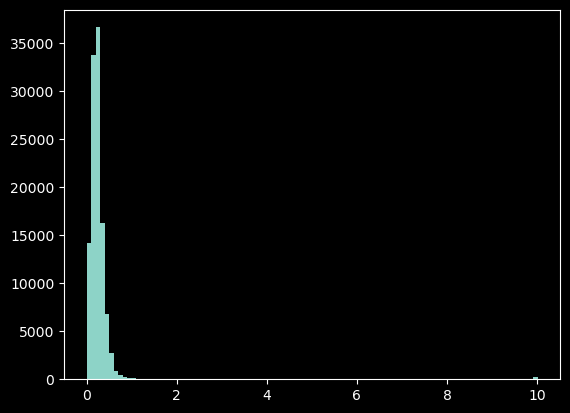

In [38]:
plt.hist(df['debttoincome'], bins = 100)

print(df.debttoincome.describe())

Looking at the debt-to-income distribution, we can see that the interquartile ratio ranges from 0.15 to 0.31. This indicates the majority of the borrowers in our dataset have lower debt-to-income ratio whilst there are borrowers with higher ratio. The max ratio is 10.01.

**2. Bivariate Visualisation**

To start with, let's see the correlation between numeric columns.



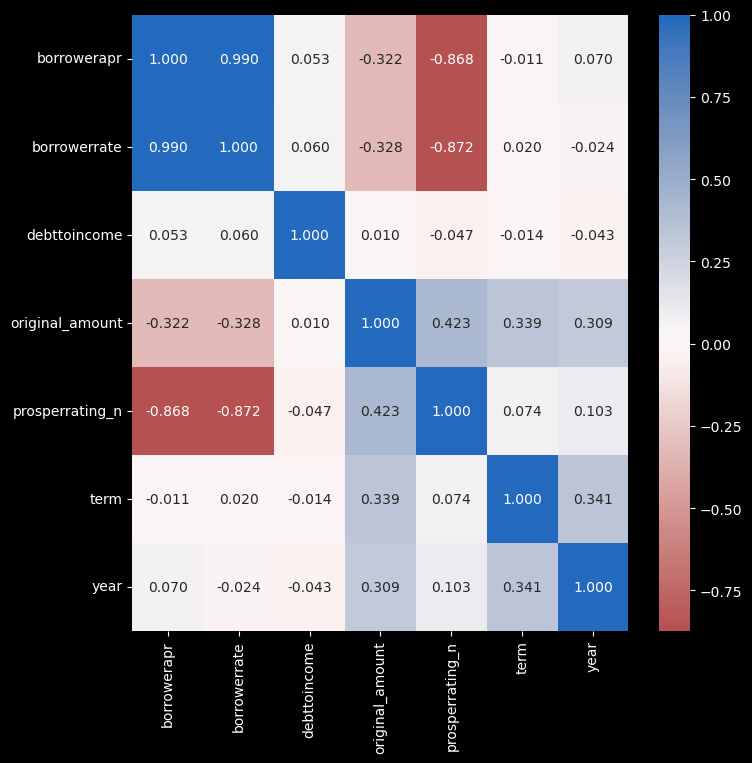

In [39]:
# Create lists for nominal and numeric columns
nom_cols = ['listingdate', 'loanstatus', 'prosperrating_a', 'listing_cat', 'employment', 'incomerange']
num_cols = df.columns.difference(nom_cols)

# Pairwise heatmap
plt.figure(figsize = [8,8])
sns.heatmap(df[num_cols].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0)
plt.show();

**Interesting Correlations**

* The first thing you might notice is the negative correlation between prosper-rating and borrowerAPR/borrower-rate. This replicates the industry norm of borrowers with higher credit scores receive lower interest rates than those with lower credit scores.

* Original amount has positive relationship with prosper-rating which explains the higher rating the higher original loan amount. This is pretty much self-explanatory as banks are more willing to allow higher loan amount to individuals with higher credit score as there is less risk.

* Other than those noteworthy correlations, there is somewhat negative relationship between borrowerAPR/borrower-rate and original amount. This means the higher original loan amount the lower interest rate. This might be highly correlated with the lenght of loan term. To be specific, the original loan amount shows positive correlation with loan term, indicating higher original loan amount has longer term. Suffice to say, borrowers pay back greater loan amount during a longer time period. And because it has longer time to pay back, borrower rate goes down.

* Basing on the aforementioned relationships, we could speculate that borrowers with higher credit score are allowed higher loan amount, interest paid in longer span of time with lower interest rate.

* Although not that strong correlation, there is a negative relationship between prosper-rating and debt-to-income ratio. This is self-explanatory that loan candidates with higher debt-to-income ration receive lower credit grade.

* We are going to ignore the correlation between similar attributes such as borrowerAPR and borrower-rate as they are basically similar features.

Now, let's explore relationship between categorical features.

**Categorical Variables VS. Original Amount**

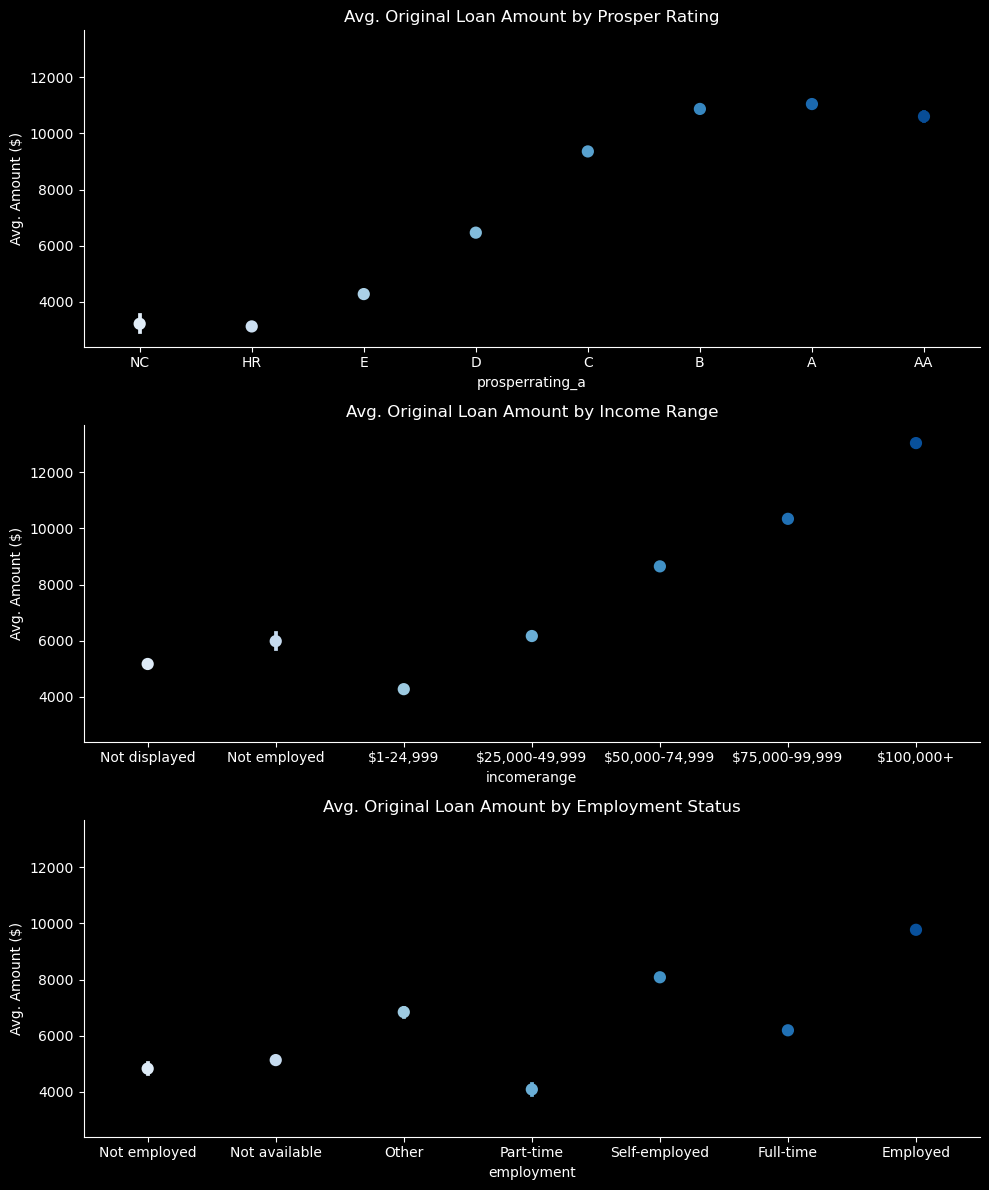

In [40]:
fig, ax = plt.subplots(nrows = 3, figsize = [10, 12], sharey = True)

grade = ['prosperrating_a', 'incomerange', 'employment']

for i in range(len(grade)):
    var = grade[i]
    sns.pointplot(data = df, x = var, y = 'original_amount', palette = "Blues", 
                    linestyles = "", ax = ax[i])
    ax[i].set_ylabel("Avg. Amount ($)")

ax[0].set_title("Avg. Original Loan Amount by Prosper Rating")  
ax[1].set_title("Avg. Original Loan Amount by Income Range")
ax[2].set_title("Avg. Original Loan Amount by Employment Status")

sns.despine()
plt.tight_layout()

plt.show();

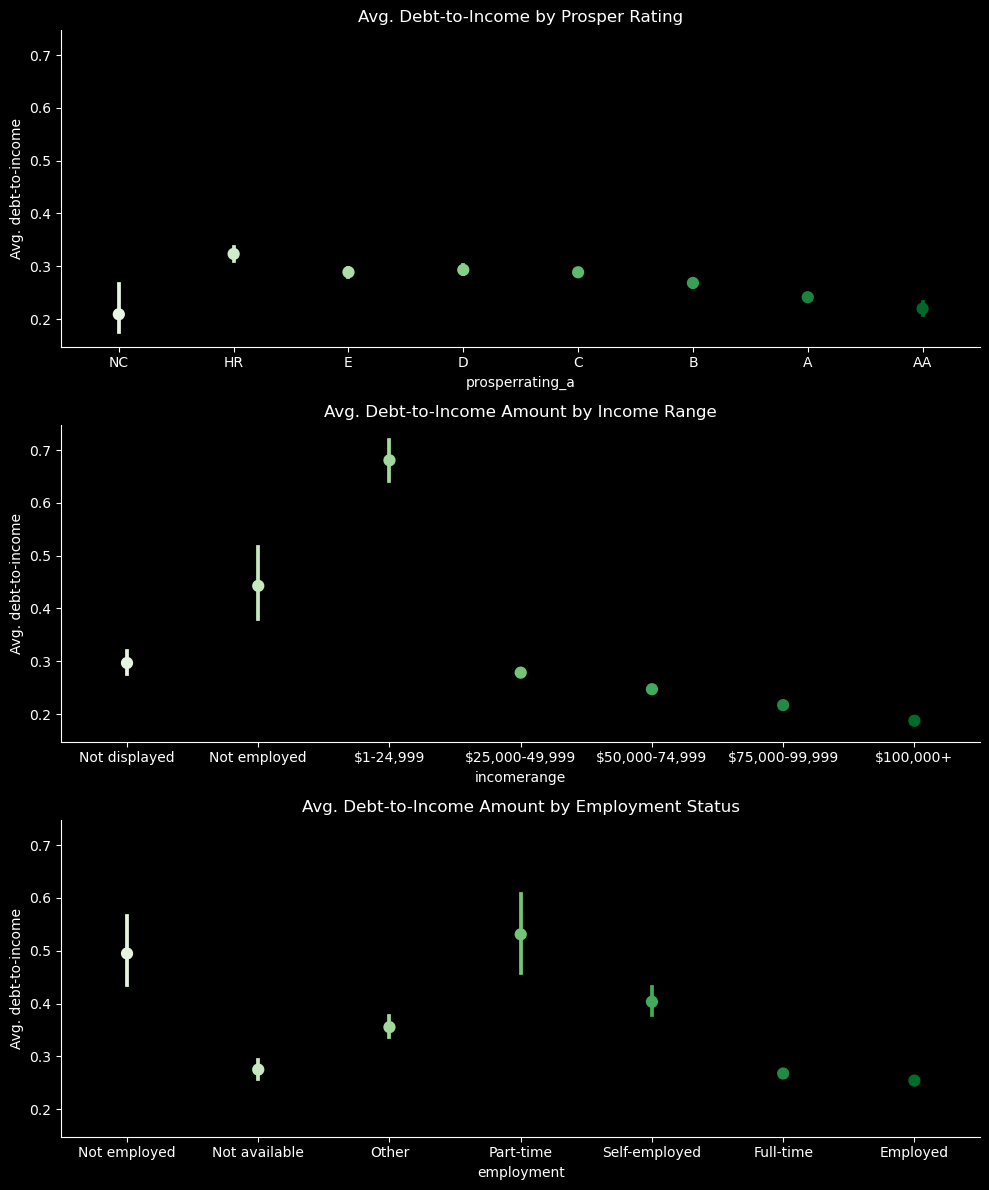

In [41]:
fig, ax = plt.subplots(nrows = 3, figsize = [10, 12], sharey = True)

grade = ['prosperrating_a', 'incomerange', 'employment']

for i in range(len(grade)):
    var = grade[i]
    sns.pointplot(data = df, x = var, y = 'debttoincome', palette = "Greens", 
                    linestyles = "", ax = ax[i])
    ax[i].set_ylabel("Avg. debt-to-income")

ax[0].set_title("Avg. Debt-to-Income by Prosper Rating")  
ax[1].set_title("Avg. Debt-to-Income Amount by Income Range")
ax[2].set_title("Avg. Debt-to-Income Amount by Employment Status")

sns.despine()
plt.tight_layout()

plt.show();

* The overall trend in avg. original loan amount increases as the credit range / prosper rating increases. This was demonstrated previously in correlation heatmap (r = 0.423). However, the interesting thing is that the curve hits plateau at prosper-rating 'B' and'A'. Then the curve come down at the best rating 'AA'. This means that despite the best credit-rating('AA'), it did not lead to the highest average loan amount in our dataset. There might be other features playing out in this correlation.

* Regarding the income range, a positive correlatioship is obvious. That is, the higher income range the higher original loan amount. However, it is interesting that borrowers with 'not employed' income range had higher avgerage loan amount than '1-24,999'. In fact its avg. loan amount was on par with that of 25,000-49,999 range. Further investigation into this issue might be helpful to understand the grounding for this. Other features might have played into decision-making such as borrowers' other assets(e.g. home owner) or recommendations.

* Generally, borrowers with constant flow of income (i.e. employed, full-time, self-employed) had higher loan amount that not-employed or retired. In short, employed / self-employed/full-time are top three whilst not-employed / part-time / retired are the last three. Nonetheless, it is interesting that not-employed borrowers had higher loan volumn that part-time. Other factors could have played in this correlation as well.

**Categorical Variables VS. Loan Status**

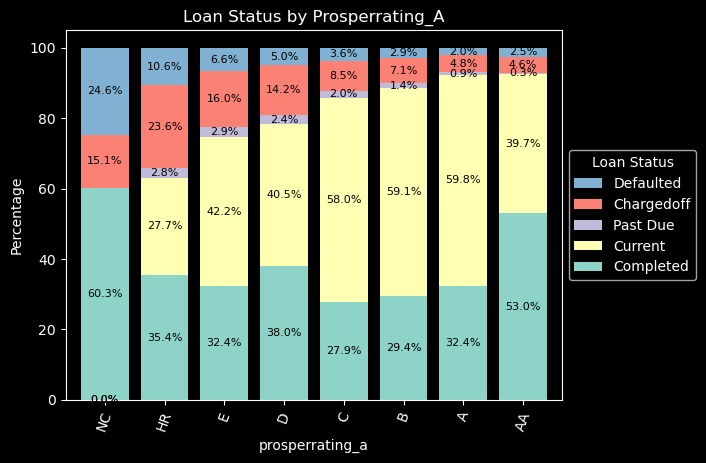

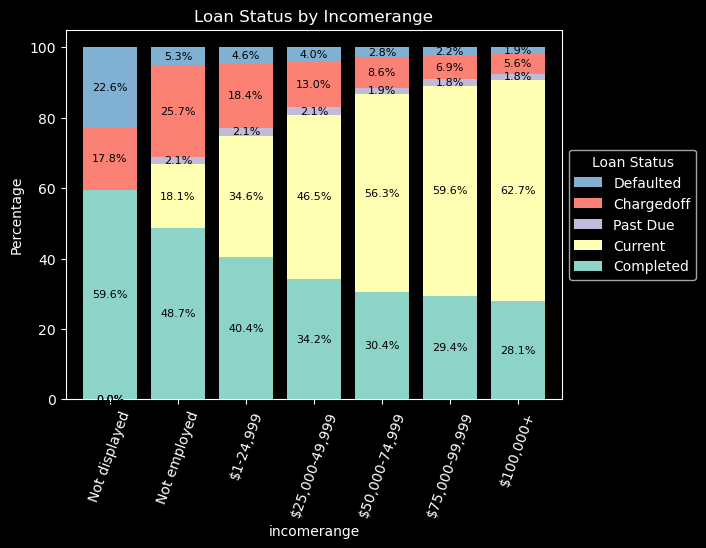

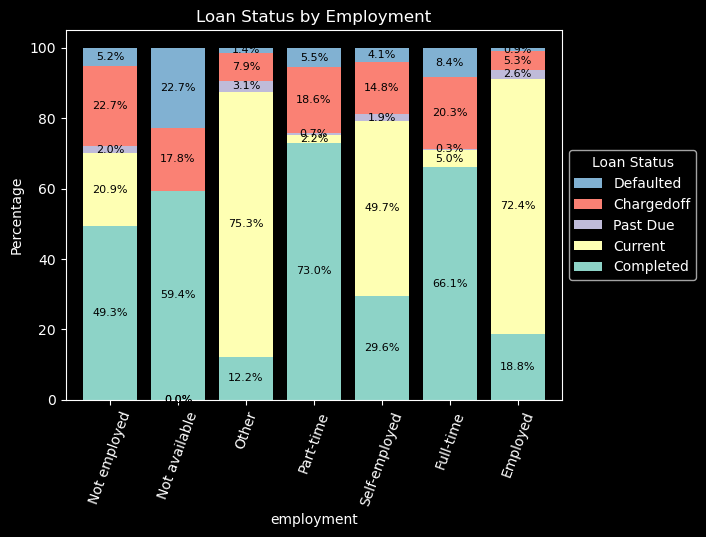

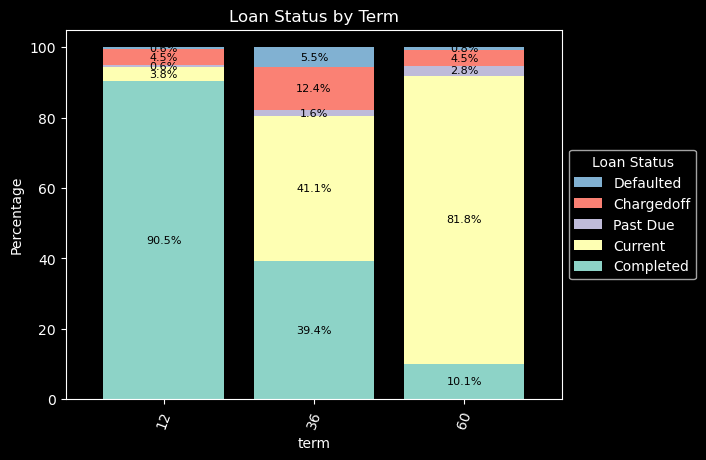

In [42]:
def loanstatus(cat1, cat2 = 'loanstatus'):
    rating_df = df.groupby(cat1)[cat2].value_counts(normalize = True).mul(100).unstack()
    ax = rating_df.plot.bar(stacked = True, rot = 0, width = 0.8) 
    # Get handles and lables to reverse the order of legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc = 'center left', bbox_to_anchor = (1, 0.5), title = 'Loan Status')
    plt.xticks(rotation = 70)
    plt.ylabel('Percentage')
    plt.title('Loan Status by {}'.format(cat1.title()))
    # add annotation
    for bar in ax.patches:
        plt.annotate(f"{bar.get_height():.1f}%",
                    (bar.get_x() + bar.get_width()/2, 
                    bar.get_y() + bar.get_height()/2), 
                    ha = 'center', va = 'center', color = 'black', fontsize = 8)
    plt.show();
    
loanstatus('prosperrating_a')
loanstatus('incomerange')
loanstatus('employment')
loanstatus('term')

When loan status are examines across different categorical variables, significant correlations are detected between prosper-rating and loan status, and income range and loan status.

* Across prosper-rating, one can see that the percentage of Defaulted decreases as the rating goes up. That means, AA has the lowest default proportion(2.5%) and HR the highest (10.9%). This is except for the not-known rating, NC. This goes the same when we include Chargedoff as a default-prone category. AA grade had the highest Completed proportion. Interesting thing is that higher grades did not automatically lead to higher completion rate. The lower percentage point of A grade than D grade is one of the examples.

* The default prone percentage decreases as the income range increases. +100K income range had the lowest percentage of 7.6%–Defaulted & Chargedoff combined–whilst the Not Employed group had 23.4%. It seems odd that the Completed proportion decreases as the income goes up. However, this doesn’t necessarily mean that higher income borrowers defaulted. As examined previously, higher income borrowers had larger loan amounts which are still in the Current category which you can see from the large Current proportion.

* Loan status by employment seems to be erratic at first sight, but when you compare the default-prone percentage, it becomes clearer. Not employed group showed 28.5% while Employed group showed 6.4%. However, the Full-time group still had a significantly high percentage point of 28.7%. This should be investigated by the lender to avoid a mistake of lending money to candidates, thinking they will pay back as they are full-time employed.

* Regarding the term, the 36-month term had the highest default-prone percentage, recording 18.2%. Both 60- and 12-month terms had low default-prone ratios.

**Original Amount VS. Loan Status**

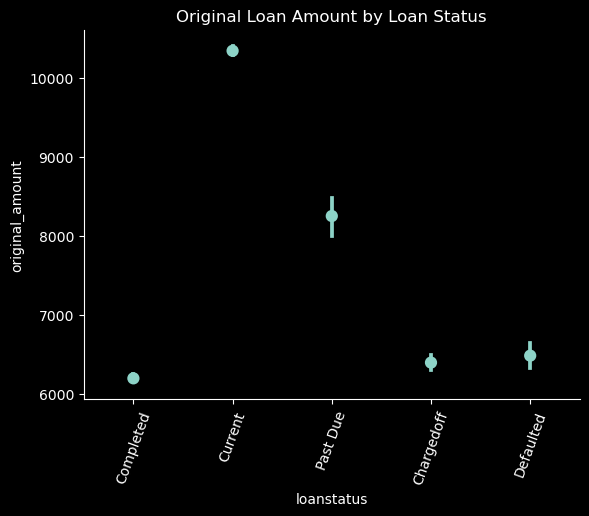

In [43]:
sns.pointplot(data = df, x = 'loanstatus', y = 'original_amount', linestyles = '')
plt.xticks(rotation = 70)
plt.title("Original Loan Amount by Loan Status")
sns.despine()
plt.show();

The graph demonstrates that default-prone statuses have higher original loan amount than completed status. However, the gap is not that noteworthy.

**Debt-to-income VS. Loan Status**

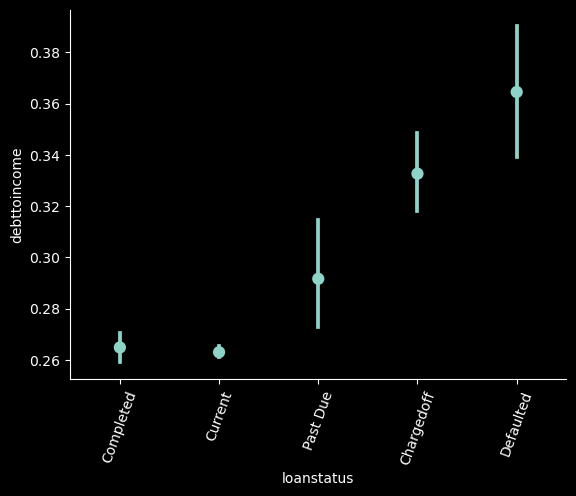

In [44]:
sns.pointplot(data = df, x = 'loanstatus', y = 'debttoincome', linestyles = "")
plt.xticks(rotation = 70)
sns.despine()
plt.show();

The graph shows a clear positive correlation between debt-to-income(dti) and loan status. This means completed loans had lower dti ration, and dti gets higher as it gets closer to default-prone status. Indeed, defaulted loans had the highest dti at around 0.375.

**3. Multivariate Exploration**

This section will focus on exploring multivariate relationships. As we have seen in bivariate exploration, we now know that prosper-rating, income range, dti and borrowerAPR has significant correlation with loan status. Therefore, we are going to explore the multivariate correlation amongst those features.

* dti | APR -- prosper-rating | income range -- loan status

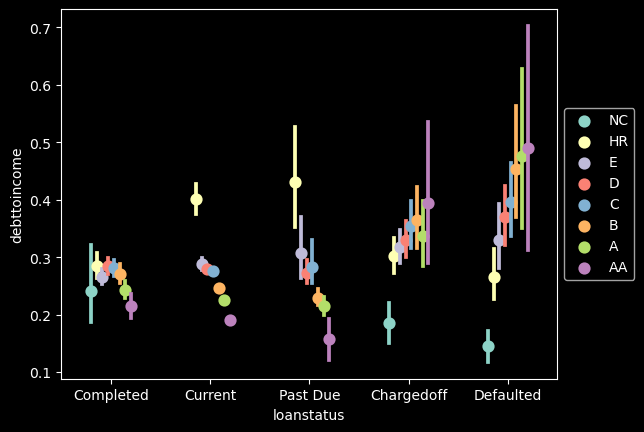

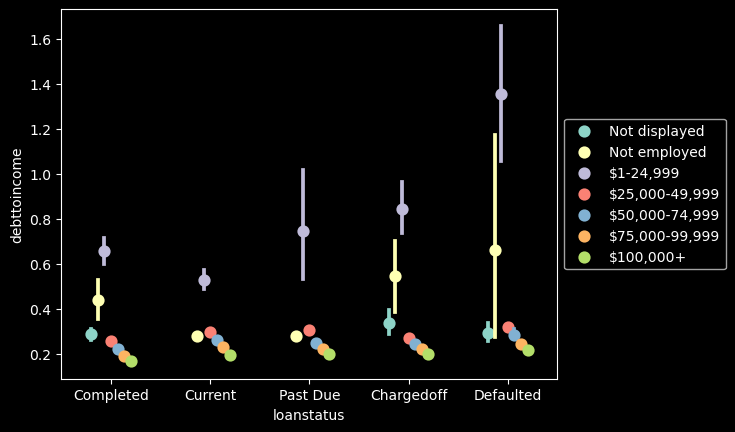

In [45]:
def pointplots(**kwargs):
    ax = sns.pointplot(data = df, x = 'loanstatus', **kwargs, linestyles = "", dodge = 0.4)
    ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    plt.show();
    
pointplots(y = 'debttoincome', hue = 'prosperrating_a')
pointplots(y = 'debttoincome', hue = 'incomerange')

The dodged plot shows a clear influence of dti to loan status as defaulted group had higher dti's. However, it is less clear across prosper-ratings with larger error bars on the right side. In the second plot, there appears to be less variance across loan status divided by employment and dti.

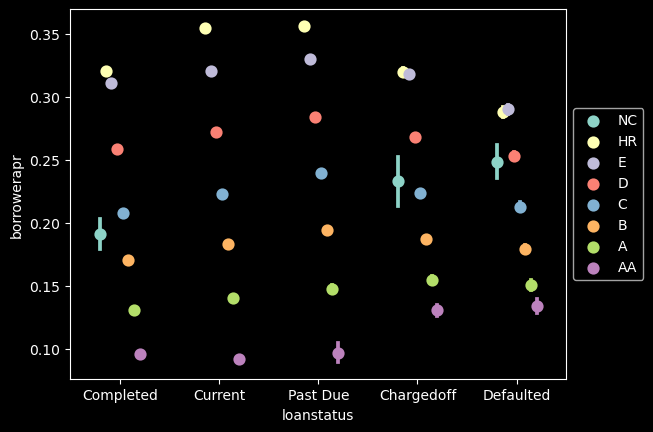

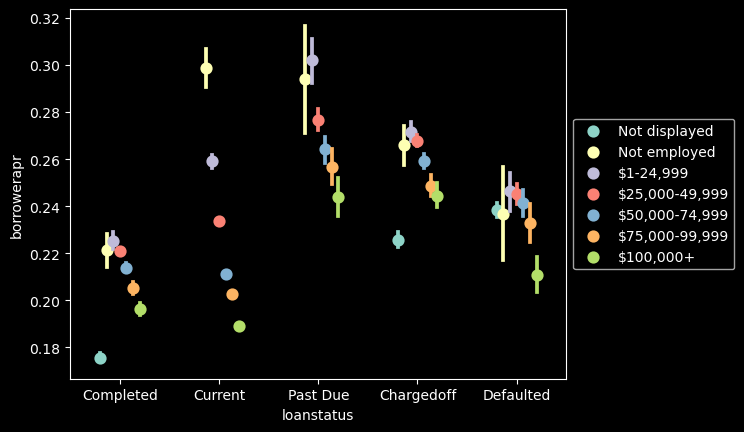

In [46]:
def pointplots(**kwargs):
    ax = sns.pointplot(data = df, x = 'loanstatus', **kwargs, linestyles = "", dodge = 0.4)
    ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    plt.show();
    
pointplots(y = 'borrowerapr', hue = 'prosperrating_a')
pointplots(y = 'borrowerapr', hue = 'incomerange')

The plot becomes less clear than bivariate exploration.

We extended the investigation of loan status against debt-to-income(dti) and borrowerAPR by looking at the impact of the two categorcial quality features (prosper-rating and income range). The multivariate exploration was less clear than expected as in bivariate correlation. It showed that there is indeed a positive effect of increased dti and APR on loan status, but in the dataset, this is disrupted by the two categorical factors creating a variance. Controlling for the dti and borrowerapr upper outliers did not impact the clarity of the plot. Looking back at multi-level exploration, bivariate relationship showed the clearest relationship between features, predecessing loan status in this dataset.